# IPCV Assignment 2

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            - 0001105149
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Dataset Download

In [3]:
# dataset download
#!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [4]:
import os
from pathlib import Path
import numpy as np

from PIL import Image
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"-{device}- is being used")

-cuda- is being used


## Auxiliary Functions

In [5]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1
    
    def get_dataloader(self, batch_size, shuffle):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle)
    
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, n_epochs=10, patience=5, device='cpu', model_name=None, verbose=True):
    model = model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    best_val_acc = -np.inf
    best_val_idx = 0
    epochs_without_improvement = 0
    
    for epoch in range(n_epochs):
        # Start timer for the epoch
        start_time = time.time()

        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train_preds, total_train_preds = 0, 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            running_loss += loss.item()  # Accumulate loss
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)
        
        # Calculate and store average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train_preds / total_train_preds
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val_preds, total_val_preds = 0, 0
        
        with torch.no_grad():  # No need to calculate gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                
                val_loss += loss.item()  # Accumulate loss
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_preds += labels.size(0)
        
        # Calculate and store average validation loss and accuracy for the epoch
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val_preds / total_val_preds
        val_accuracies.append(val_accuracy)
        
        # Calculate the time taken for this epoch
        epoch_time = time.time() - start_time

        # Print training, validation results, and epoch time
        if verbose:
            print(f"Epoch [{epoch+1}/{n_epochs}] "
                  f"Time: {epoch_time:.2f} seconds, "
                  f"Train Loss: {train_losses[-1]:.6f}, "
                  f"Train Accuracy: {train_accuracies[-1]:.6f}, "
                  f"Val Loss: {val_losses[-1]:.6f}, "
                  f"Val Accuracy: {val_accuracies[-1]:.6f}")
        
        # Early stopping check
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            best_val_idx = len(val_accuracies) - 1
            epochs_without_improvement = 0  # Reset counter if we have improvement
            
            # Save current best weights
            if model_name:
                torch.save(model.state_dict(), os.path.join("weights", f"{model_name}.pth"))
        else:
            epochs_without_improvement += 1  # Increment counter if no improvement

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Best validation accuracy of {best_val_acc:.6f} found at epoch {best_val_idx + 1}.")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_idx


def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, best_val_idx, title=None):
    epochs = range(1, len(train_losses) + 1)

    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(epochs, train_losses, label='Train Loss', color='blue')
    axs[0].plot(epochs, val_losses, label='Val Loss', color='orange')
    axs[0].axvline(best_val_idx + 1, color='red', linestyle='--', label='Best Epoch')
    axs[0].set_title('Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    axs[1].plot(epochs, val_accuracies, label='Val Accuracy', color='orange')
    axs[1].axvline(best_val_idx + 1, color='red', linestyle='--', label='Best Epoch')
    axs[1].set_title('Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Highlight the best epoch in both subplots
    axs[0].scatter(best_val_idx + 1, val_losses[best_val_idx], color='red', zorder=5)
    axs[1].scatter(best_val_idx + 1, val_accuracies[best_val_idx], color='red', zorder=5)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()


## Dataset Statistics and Configuration

The following cell computes key statistics of the dataset, including the mean and standard deviation of pixel values for each color channel (RGB). The train, validation, and test sets are combined, and each image is processed to:
- Track image dimensions.
- Calculate the mean and standard deviation for normalization.

A configuration dictionary (config) is also created, storing hyperparameters like image resize and cropping size, batch size, learning rate, and the computed mean and standard deviation for preprocessing.

In [6]:
# Global dataset with no transformations
train_dataset_no_preprocessing = GroceryStoreDataset("train", transform=transforms.ToTensor())
val_dataset_no_preprocessing = GroceryStoreDataset("val", transform=transforms.ToTensor())
test_dataset_no_preprocessing = GroceryStoreDataset("test", transform=transforms.ToTensor())
global_dataset = torch.utils.data.ConcatDataset([train_dataset_no_preprocessing, val_dataset_no_preprocessing, test_dataset_no_preprocessing])

# Initialize variables to accumulate mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_pixels = 0

# Dictionary to keep track of image shapes
shapes = {}

# Loop through the global dataset
for img, _ in tqdm(global_dataset, desc="Collecting image dimensions and computing statistics"):
    channels, height, width = img.shape
    
    # Update shape occurrences
    if shapes.get((width, height)) is None:
        shapes[(width, height)] = 1
    else:
        shapes[(width, height)] += 1

    # Compute the number of pixels per image
    num_pixels += height * width
    
    # Sum the mean values of each channel (mean for each pixel)
    mean += img.view(channels, -1).mean(dim=1)
    
    # Sum the squared differences for std calculation
    std += img.view(channels, -1).std(dim=1)

# Divide the sum of means and std by the total number of images to get the final mean and std
mean /= len(global_dataset)
std /= len(global_dataset)


print("Mean and standard deviation of image channels:")
print(f"Mean: {mean}")
print(f"Std: {std}")

print("\nShapes of images in the dataset")
for shape, occurrences in shapes.items():
    print(f"Shape: {shape} \t Occurrences: {occurrences}")
    

Mean and standard deviation of image channels:
Mean: tensor([0.5278, 0.3966, 0.2577])
Std: tensor([0.2337, 0.2101, 0.1793])

Shapes of images in the dataset
Shape: (348, 348) 	 Occurrences: 4958
Shape: (348, 464) 	 Occurrences: 426
Shape: (464, 348) 	 Occurrences: 37


In [7]:
config = {
          "crop_size": 300,
      
          "batch_size": 64,
          "num_epochs": 100,
      
          "learning_rate": 5e-4,
          "patience": 10,
    
          "global_mean": mean,
          "global_std": std
}

## Data Augmentation and Preprocessing

This section defines separate preprocessing pipelines for the training and validation sets:

Training set - Data augmentation techniques are applied to improve the model's generalization.
- RandomResizedCrop: Randomly crops images to the target size (crop_size found during the global dataset analysis). This allows to both introduce variability in the training samples and convert every input to a standard dimension.
- RandomHorizontalFlip and RandomVerticalFlip: Randomly flip the images to increase diversity and improve model generalization.
- ToTensor: Converts images to tensors.
- Normalize: Standardizes the pixel values using the computed global mean and standard deviation. This step stabilizes training and improves convergence by ensuring the input values have a mean of 0 and standard deviation of 1.

Validation set - No augmentation is applied to the validation data to ensure consistency.
- Resize and CenterCrop: Resize images to a fixed size in order to avoid dimension mismatches.
- ToTensor and Normalize: Similar to training, this ensures the validation set follows the same normalization procedure as the training data, but without augmentation.

In [8]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(config["crop_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(config["global_mean"], config["global_std"])
])

transform_val = transforms.Compose([
    transforms.CenterCrop(config["crop_size"]),
    transforms.ToTensor(),
    transforms.Normalize(config["global_mean"], config["global_std"])
])


train_set = GroceryStoreDataset("train", transform=transform_train)
val_set = GroceryStoreDataset("val", transform=transform_val)

## Part 1: Custom Model

We start from a custom model able to reach a target accuracy >60%. This model, named CNN_v1 is composed of:
- Six convolutional layers. The initial layers use smaller filter sizes and fewer output channels, gradually increasing the depth and complexity. This design helps capture low-level features like edges and textures initially and more abstract features in the deeper layers.

- Batch Normalization: Each convolutional layer is followed by a batch normalization layer. This normalizes the activations, which stabilizes and accelerates training, and helps prevent overfitting.

- Activation Function: The ReLU activation function is employed after each convolutional layer. ReLU introduces non-linearity to the model, allowing it to learn more complex patterns without the vanishing gradient problem associated with sigmoid or tanh activations.

- Max Pooling Layers: Max pooling layers reduce the spatial dimensions, downsampling the feature maps while retaining important features. This helps in reducing the computational load and controlling overfitting.

- Adaptive Average Pooling: An adaptive average pooling layer is used before the fully connected layers, ensuring a fixed output size regardless of the input dimensions. Although, this makes the model more flexible with input sizes, in this specific case the data preprocessing line ensures that every image is resized to a fixed size. Thus, the adaptive average pooling layer is primarily used to downsample the input from shape (batch_size, 64, 9, 9) to (batch_size, 64, 6, 6).

- Classification Head: The model ends with two fully connected layers. The first layer reduces the feature dimension to 128, and the second layer outputs predictions for the specified number of classes. The use of fully connected layers allows for combining learned features to make final class predictions.

In [8]:
class CNN_v1(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_v1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same") 
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding="same")
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.bn4 = nn.BatchNorm2d(32)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.bn5 = nn.BatchNorm2d(64)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.bn6 = nn.BatchNorm2d(64)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        
        x = self.avg_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
    
CNN_v1 = CNN_v1()
CNN_v1 = CNN_v1.to(device)
summary(CNN_v1, input_size=(3, config["crop_size"], config["crop_size"]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 300]           1,216
       BatchNorm2d-2         [-1, 16, 300, 300]              32
         MaxPool2d-3         [-1, 16, 150, 150]               0
            Conv2d-4         [-1, 16, 150, 150]           6,416
       BatchNorm2d-5         [-1, 16, 150, 150]              32
         MaxPool2d-6           [-1, 16, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           4,640
       BatchNorm2d-8           [-1, 32, 75, 75]              64
         MaxPool2d-9           [-1, 32, 37, 37]               0
           Conv2d-10           [-1, 32, 37, 37]           9,248
      BatchNorm2d-11           [-1, 32, 37, 37]              64
        MaxPool2d-12           [-1, 32, 18, 18]               0
           Conv2d-13           [-1, 64, 18, 18]          18,496
      BatchNorm2d-14           [-1, 64,

In [9]:
train_losses_v1, val_losses_v1, train_acc_v1, val_acc_v1, best_epoch_v1 = train_and_validate(CNN_v1, 
                                                                                             train_set.get_dataloader(config["batch_size"], shuffle=True), 
                                                                                             val_set.get_dataloader(config["batch_size"], shuffle=False),
                                                                                             criterion=nn.CrossEntropyLoss(),
                                                                                             optimizer=optim.Adam(CNN_v1.parameters(), lr=config["learning_rate"]),
                                                                                             n_epochs=config["num_epochs"],
                                                                                             device=device,
                                                                                             patience=config["patience"],
                                                                                             model_name="cnn_v1")


Epoch [1/100] Time: 12.15 seconds, Train Loss: 2.847045, Train Accuracy: 0.242424, Val Loss: 2.652630, Val Accuracy: 0.266892
Epoch [2/100] Time: 11.89 seconds, Train Loss: 2.168404, Train Accuracy: 0.362500, Val Loss: 2.526178, Val Accuracy: 0.280405
Epoch [3/100] Time: 12.00 seconds, Train Loss: 1.873892, Train Accuracy: 0.429924, Val Loss: 2.145520, Val Accuracy: 0.341216
Epoch [4/100] Time: 12.25 seconds, Train Loss: 1.715586, Train Accuracy: 0.463258, Val Loss: 2.176988, Val Accuracy: 0.334459
Epoch [5/100] Time: 11.22 seconds, Train Loss: 1.546711, Train Accuracy: 0.497348, Val Loss: 1.955799, Val Accuracy: 0.368243
Epoch [6/100] Time: 11.64 seconds, Train Loss: 1.417421, Train Accuracy: 0.548485, Val Loss: 1.906296, Val Accuracy: 0.385135
Epoch [7/100] Time: 11.71 seconds, Train Loss: 1.356431, Train Accuracy: 0.561364, Val Loss: 1.848087, Val Accuracy: 0.418919
Epoch [8/100] Time: 11.74 seconds, Train Loss: 1.306796, Train Accuracy: 0.567803, Val Loss: 1.839237, Val Accuracy: 0

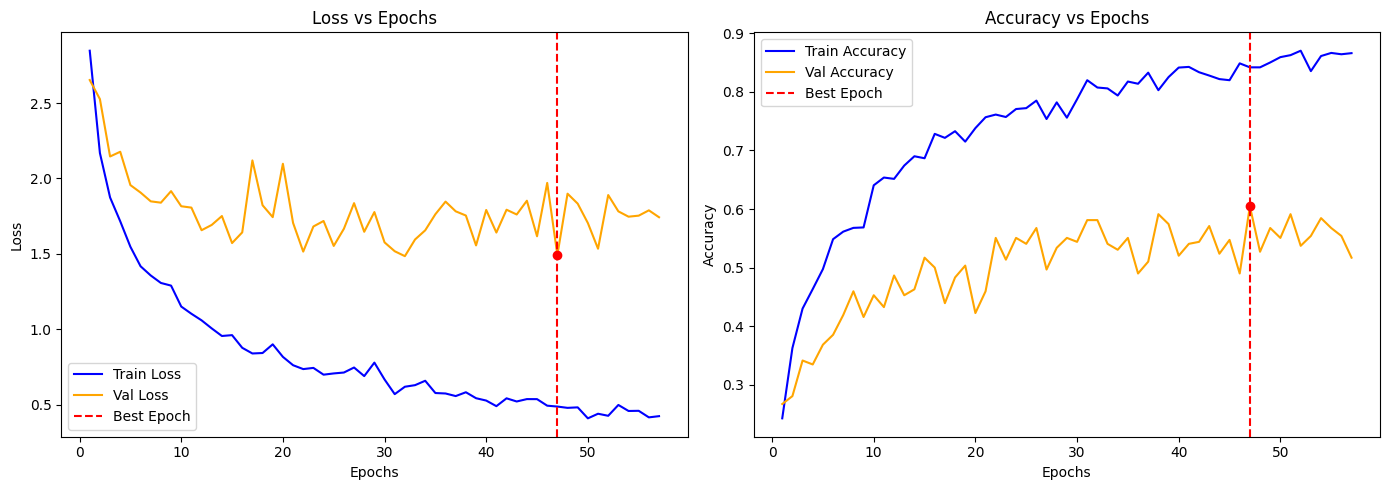

In [10]:
plot_training_results(train_losses_v1, val_losses_v1, train_acc_v1, val_acc_v1, best_epoch_v1)

## Ablation Study on Custom model

### Removing Batch Normalization

In [10]:
class CNN_no_bn(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_no_bn, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same")
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding="same")
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv6(x)
        x = F.relu(x)
        
        x = self.avg_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
    
CNN_no_bn = CNN_no_bn()
CNN_no_bn = CNN_no_bn.to(device)
summary(CNN_no_bn, input_size=(3, config["crop_size"], config["crop_size"]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 300]           1,216
         MaxPool2d-2         [-1, 16, 150, 150]               0
            Conv2d-3         [-1, 16, 150, 150]           6,416
         MaxPool2d-4           [-1, 16, 75, 75]               0
            Conv2d-5           [-1, 32, 75, 75]           4,640
         MaxPool2d-6           [-1, 32, 37, 37]               0
            Conv2d-7           [-1, 32, 37, 37]           9,248
         MaxPool2d-8           [-1, 32, 18, 18]               0
            Conv2d-9           [-1, 64, 18, 18]          18,496
        MaxPool2d-10             [-1, 64, 9, 9]               0
           Conv2d-11             [-1, 64, 9, 9]          36,928
AdaptiveAvgPool2d-12             [-1, 64, 6, 6]               0
           Linear-13                  [-1, 128]         295,040
           Linear-14                   

In [11]:
train_losses_no_bn, val_losses_no_bn, train_acc_no_bn, val_acc_no_bn, best_epoch_no_bn = train_and_validate(CNN_no_bn, 
                                                                                         train_set.get_dataloader(config["batch_size"], shuffle=True), 
                                                                                         val_set.get_dataloader(config["batch_size"], shuffle=False),
                                                                                         criterion=nn.CrossEntropyLoss(),
                                                                                         optimizer=optim.Adam(CNN_no_bn.parameters(), lr=config["learning_rate"]),
                                                                                         n_epochs=config["num_epochs"],
                                                                                         device=device,
                                                                                         patience=config["patience"],
                                                                                         model_name="CNN_no_bn")

Epoch [1/100] Time: 9.03 seconds, Train Loss: 3.492825, Train Accuracy: 0.103409, Val Loss: 3.402633, Val Accuracy: 0.152027, 
Epoch [2/100] Time: 9.13 seconds, Train Loss: 3.152618, Train Accuracy: 0.173485, Val Loss: 3.084450, Val Accuracy: 0.199324, 
Epoch [3/100] Time: 9.00 seconds, Train Loss: 2.879544, Train Accuracy: 0.212121, Val Loss: 3.178139, Val Accuracy: 0.175676, 
Epoch [4/100] Time: 9.07 seconds, Train Loss: 2.710355, Train Accuracy: 0.246591, Val Loss: 2.788835, Val Accuracy: 0.212838, 
Epoch [5/100] Time: 8.99 seconds, Train Loss: 2.488876, Train Accuracy: 0.247348, Val Loss: 2.609544, Val Accuracy: 0.233108, 
Epoch [6/100] Time: 8.87 seconds, Train Loss: 2.345524, Train Accuracy: 0.275000, Val Loss: 2.632474, Val Accuracy: 0.290541, 
Epoch [7/100] Time: 8.95 seconds, Train Loss: 2.323020, Train Accuracy: 0.280682, Val Loss: 2.673984, Val Accuracy: 0.222973, 
Epoch [8/100] Time: 8.90 seconds, Train Loss: 2.221080, Train Accuracy: 0.313636, Val Loss: 2.596483, Val Accur

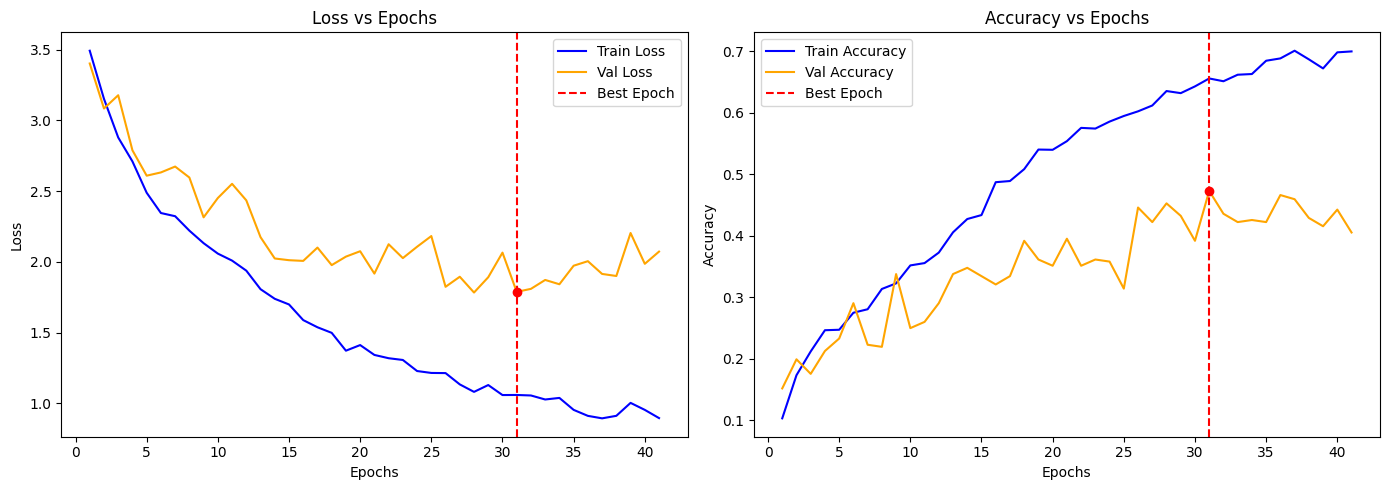

In [12]:
plot_training_results(train_losses_no_bn, val_losses_no_bn, train_acc_no_bn, val_acc_no_bn, best_epoch_no_bn)

### Removing Max Pooling

In [13]:
class CNN_no_mp(nn.Module):
    def __init__(self, n_classes=43):
        super(CNN_no_mp, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding="same") 
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding="same")
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.bn4 = nn.BatchNorm2d(32)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.bn5 = nn.BatchNorm2d(64)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.bn6 = nn.BatchNorm2d(64)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Adjust the input size of the fully connected layer based on the pooling output size
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        
        x = self.avg_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
    
CNN_no_mp = CNN_no_mp()
CNN_no_mp = CNN_no_mp.to(device)
summary(CNN_no_mp, input_size=(3, config["crop_size"], config["crop_size"]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 300]           1,216
       BatchNorm2d-2         [-1, 16, 300, 300]              32
            Conv2d-3         [-1, 16, 300, 300]           6,416
       BatchNorm2d-4         [-1, 16, 300, 300]              32
            Conv2d-5         [-1, 32, 300, 300]           4,640
       BatchNorm2d-6         [-1, 32, 300, 300]              64
            Conv2d-7         [-1, 32, 300, 300]           9,248
       BatchNorm2d-8         [-1, 32, 300, 300]              64
            Conv2d-9         [-1, 64, 300, 300]          18,496
      BatchNorm2d-10         [-1, 64, 300, 300]             128
           Conv2d-11         [-1, 64, 300, 300]          36,928
      BatchNorm2d-12         [-1, 64, 300, 300]             128
AdaptiveAvgPool2d-13             [-1, 64, 6, 6]               0
           Linear-14                  [

In [14]:
train_losses_no_mp, val_losses_no_mp, train_acc_no_mp, val_acc_no_mp, best_epoch_no_mp = train_and_validate(CNN_no_mp, 
                                                                                         train_set.get_dataloader(config["batch_size"], shuffle=True), 
                                                                                         val_set.get_dataloader(config["batch_size"], shuffle=False),
                                                                                         criterion=nn.CrossEntropyLoss(),
                                                                                         optimizer=optim.Adam(CNN_no_mp.parameters(), lr=config["learning_rate"]),
                                                                                         n_epochs=config["num_epochs"],
                                                                                         device=device,
                                                                                         patience=config["patience"],
                                                                                         model_name="CNN_no_mp")

Epoch [1/100] Time: 526.77 seconds, Train Loss: 2.911985, Train Accuracy: 0.230682, Val Loss: 2.768172, Val Accuracy: 0.222973, 
Epoch [2/100] Time: 518.89 seconds, Train Loss: 2.240060, Train Accuracy: 0.358712, Val Loss: 2.538731, Val Accuracy: 0.273649, 
Epoch [3/100] Time: 518.10 seconds, Train Loss: 1.993729, Train Accuracy: 0.399242, Val Loss: 2.257861, Val Accuracy: 0.320946, 
Epoch [4/100] Time: 517.24 seconds, Train Loss: 1.780174, Train Accuracy: 0.449621, Val Loss: 2.386219, Val Accuracy: 0.320946, 
Epoch [5/100] Time: 517.03 seconds, Train Loss: 1.703814, Train Accuracy: 0.458712, Val Loss: 2.177180, Val Accuracy: 0.388514, 
Epoch [6/100] Time: 517.31 seconds, Train Loss: 1.647371, Train Accuracy: 0.479167, Val Loss: 1.981383, Val Accuracy: 0.412162, 
Epoch [7/100] Time: 516.75 seconds, Train Loss: 1.513857, Train Accuracy: 0.511364, Val Loss: 2.042797, Val Accuracy: 0.378378, 
Epoch [8/100] Time: 516.88 seconds, Train Loss: 1.488661, Train Accuracy: 0.526136, Val Loss: 2.1

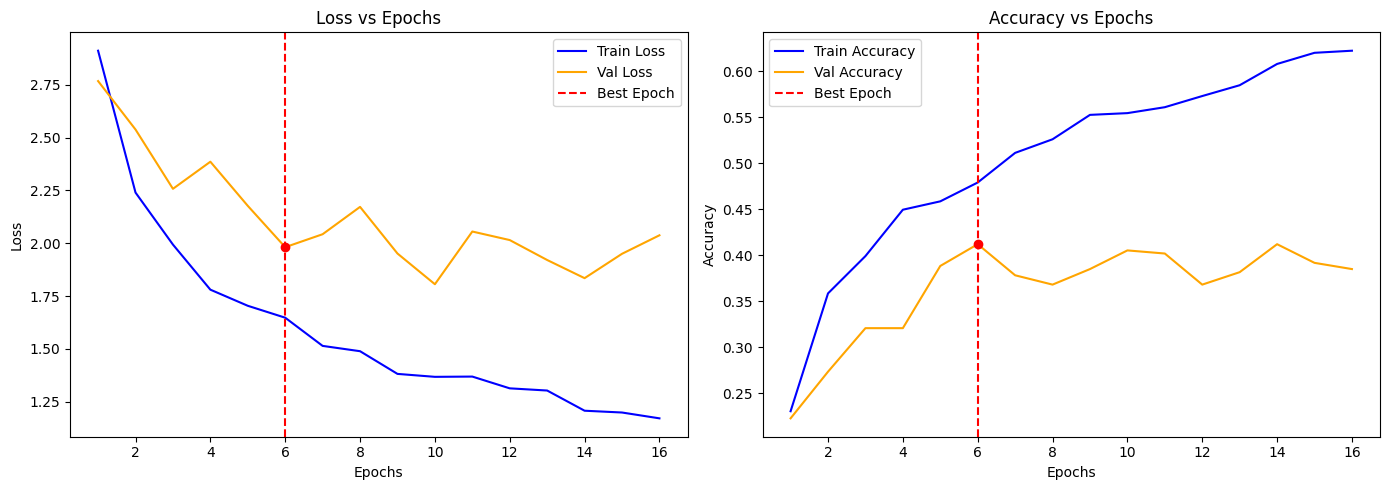

In [15]:
plot_training_results(train_losses_no_mp, val_losses_no_mp, train_acc_no_mp, val_acc_no_mp, best_epoch_no_mp)

## Part 2:  Res-Net Fine Tuning

## Resn-Net with Parameters Used Above

In [15]:
def set_requires_grad(layer: torch.nn.Module, train: bool):
    for p in layer.parameters():
        p.requires_grad = train
        
def get_resnet18(num_classes: int, weights: ResNet18_Weights):
    model = resnet18(weights=weights)
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    set_requires_grad(model.conv1, False)
    set_requires_grad(model.bn1, False)
    set_requires_grad(model.layer1, False)
    set_requires_grad(model.layer2, False)
    set_requires_grad(model.layer3, False)
    set_requires_grad(model.layer4, False)
    
    return model

resnet18_v1 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18_v1 = resnet18_v1.to(device)
summary(resnet18_v1, input_size=(3, config["crop_size"], config["crop_size"]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

In [9]:
train_losses_resnet_v1, val_losses_resnet_v1, train_acc_resnet_v1, val_acc_resnet_v1, best_epoch_resnet_v1 = train_and_validate(resnet18_v1, 
                                                                                             train_set.get_dataloader(config["batch_size"], shuffle=True), 
                                                                                             val_set.get_dataloader(config["batch_size"], shuffle=False),
                                                                                             criterion=nn.CrossEntropyLoss(),
                                                                                             optimizer=optim.Adam(resnet18_v1.parameters(), lr=config["learning_rate"]),
                                                                                             n_epochs=config["num_epochs"],
                                                                                             device=device,
                                                                                             patience=config["patience"],
                                                                                             model_name="resnet18_v1")


Epoch [1/100] Time: 9.89 seconds, Train Loss: 3.228301, Train Accuracy: 0.163636, Val Loss: 2.842280, Val Accuracy: 0.243243
Epoch [2/100] Time: 10.36 seconds, Train Loss: 2.494080, Train Accuracy: 0.364773, Val Loss: 2.318513, Val Accuracy: 0.398649
Epoch [3/100] Time: 10.56 seconds, Train Loss: 2.039008, Train Accuracy: 0.495833, Val Loss: 1.973076, Val Accuracy: 0.472973
Epoch [4/100] Time: 10.28 seconds, Train Loss: 1.732044, Train Accuracy: 0.598864, Val Loss: 1.762274, Val Accuracy: 0.547297
Epoch [5/100] Time: 10.70 seconds, Train Loss: 1.488768, Train Accuracy: 0.655682, Val Loss: 1.537421, Val Accuracy: 0.591216
Epoch [6/100] Time: 10.63 seconds, Train Loss: 1.325377, Train Accuracy: 0.700758, Val Loss: 1.438490, Val Accuracy: 0.604730
Epoch [7/100] Time: 10.08 seconds, Train Loss: 1.199678, Train Accuracy: 0.743939, Val Loss: 1.286893, Val Accuracy: 0.685811
Epoch [8/100] Time: 9.50 seconds, Train Loss: 1.088921, Train Accuracy: 0.764394, Val Loss: 1.241751, Val Accuracy: 0.6

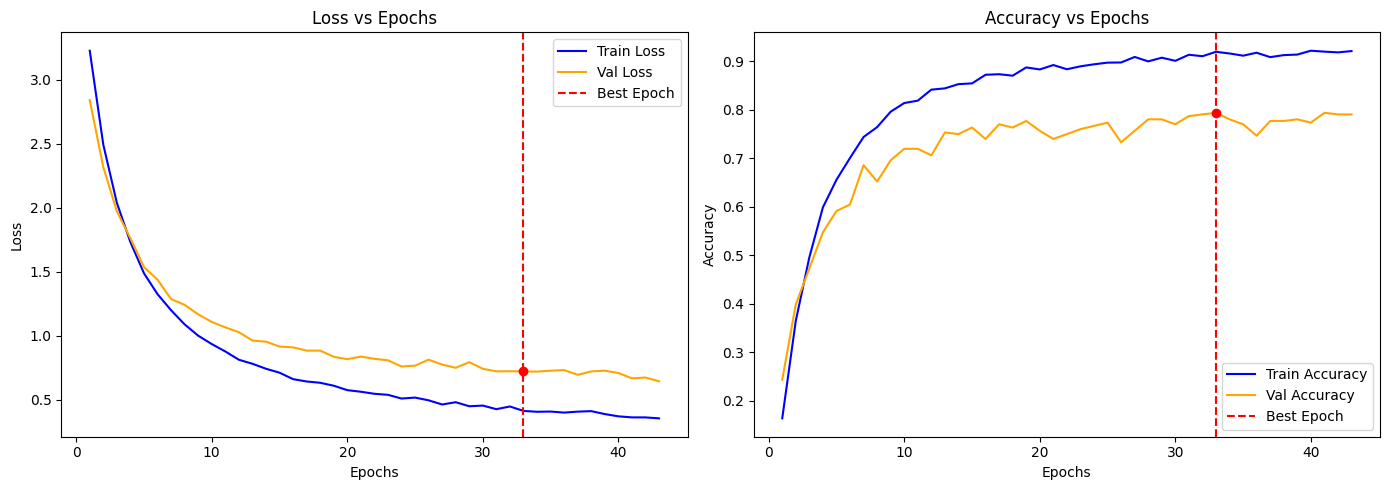

In [10]:
plot_training_results(train_losses_resnet_v1, val_losses_resnet_v1, train_acc_resnet_v1, val_acc_resnet_v1, best_epoch_resnet_v1)

## Resn-Net with Selected Parameters

Early stopping triggered. Best validation accuracy of 0.777027 found at epoch 21.


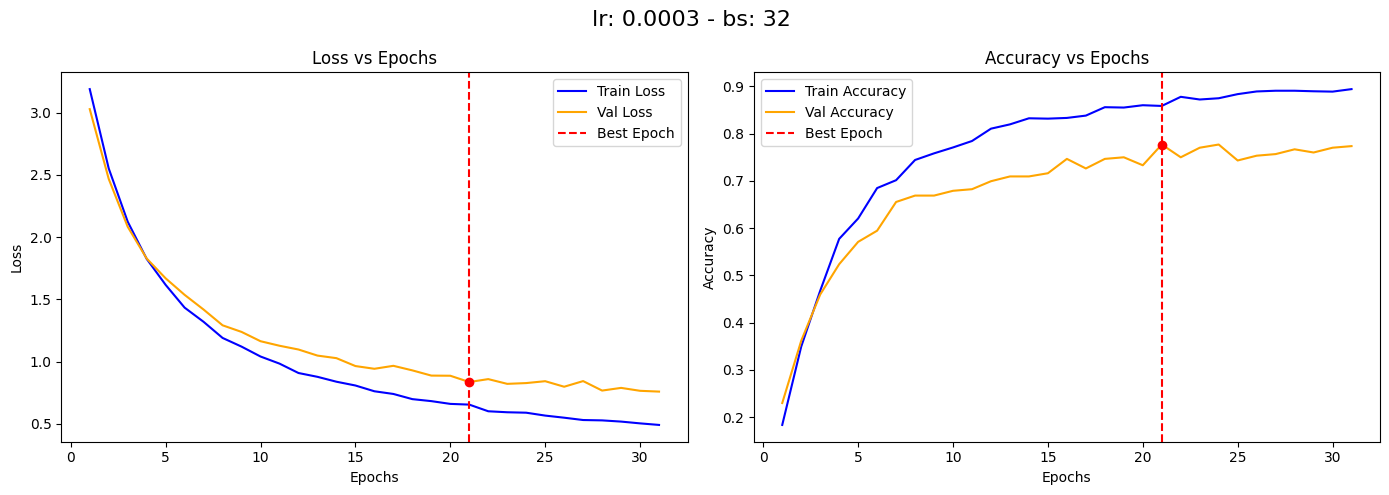


Early stopping triggered. Best validation accuracy of 0.790541 found at epoch 51.


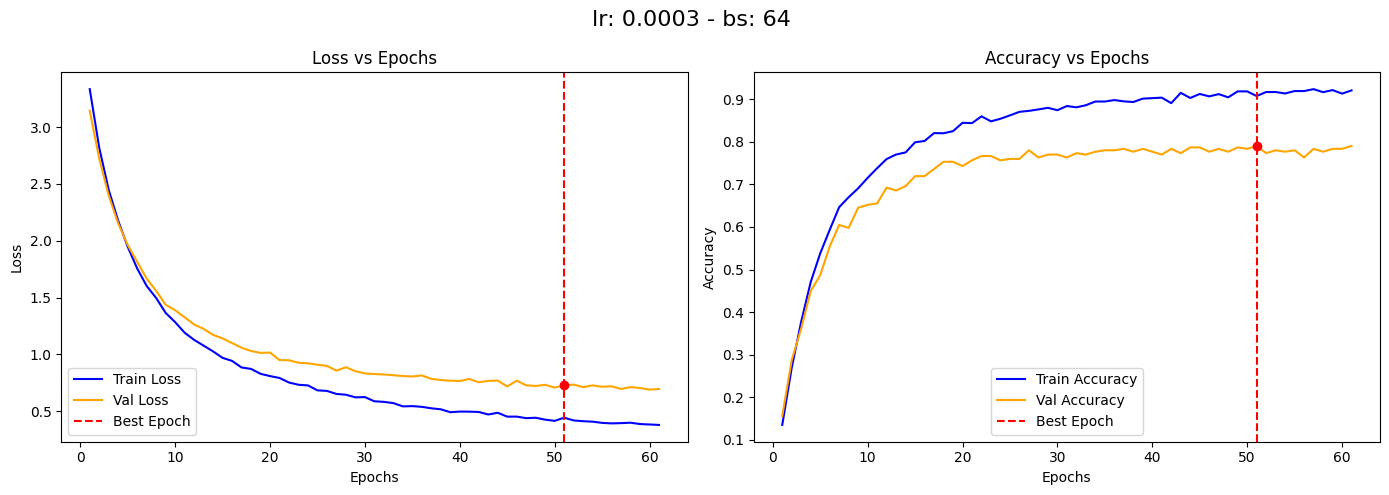


Early stopping triggered. Best validation accuracy of 0.790541 found at epoch 69.


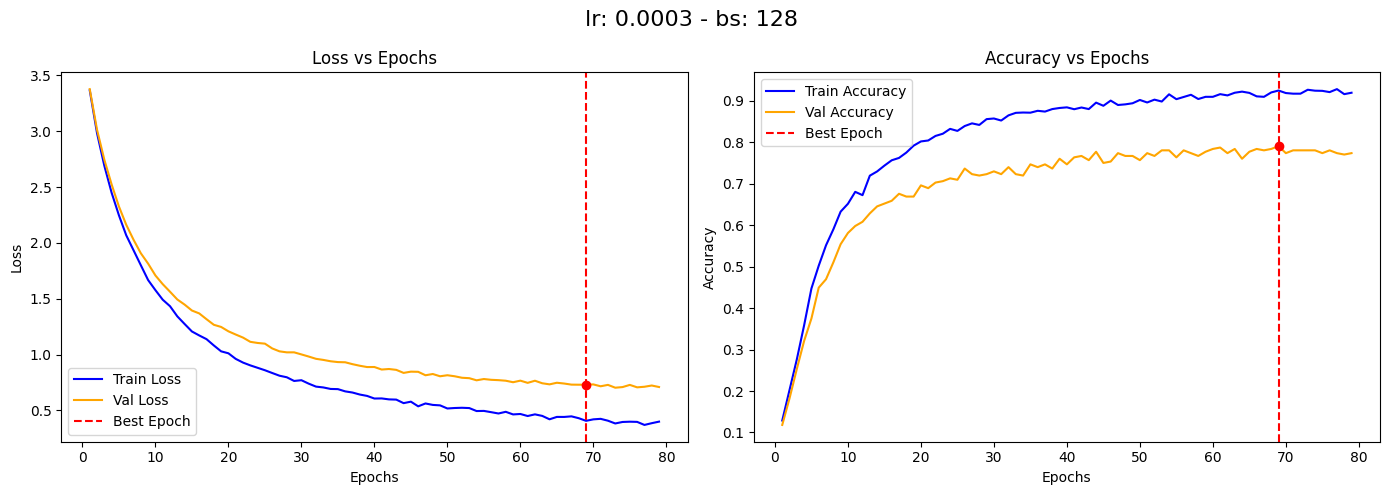


Early stopping triggered. Best validation accuracy of 0.804054 found at epoch 22.


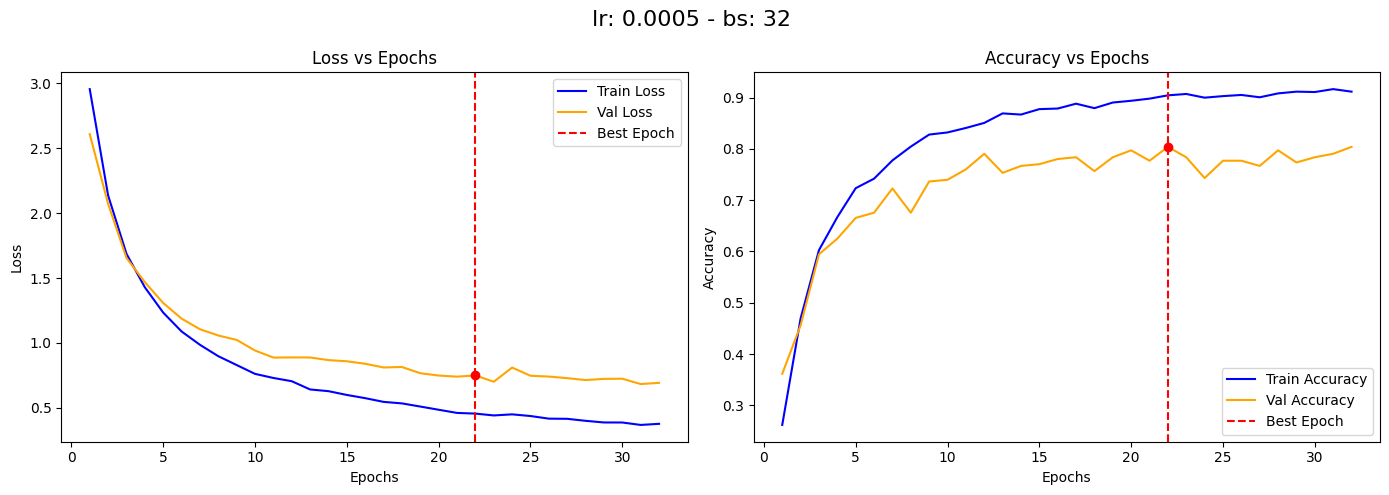


Early stopping triggered. Best validation accuracy of 0.793919 found at epoch 34.


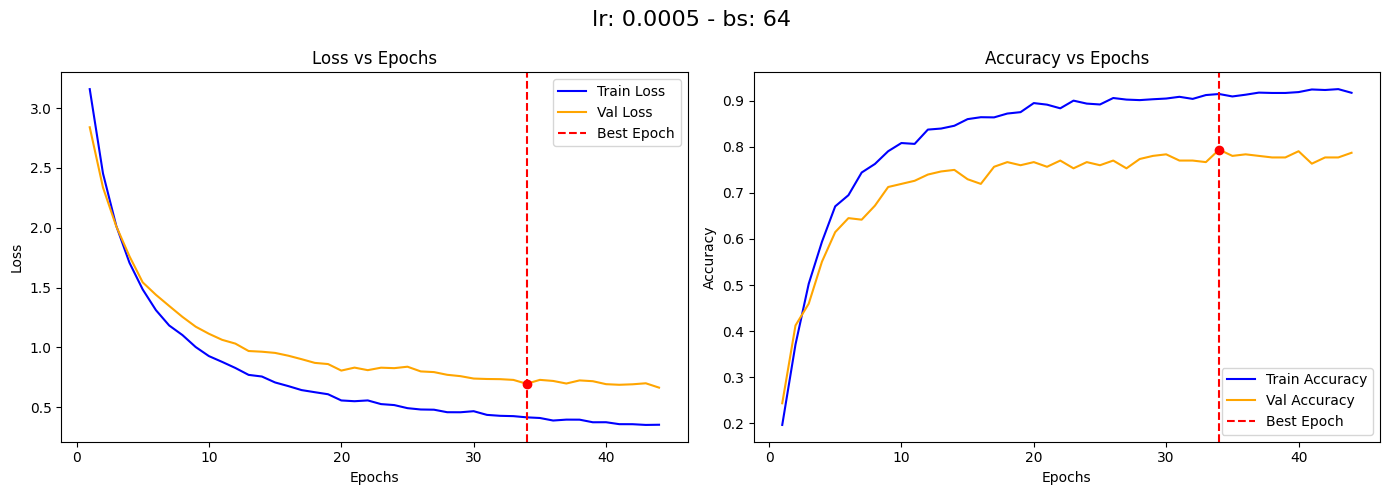


Early stopping triggered. Best validation accuracy of 0.787162 found at epoch 51.


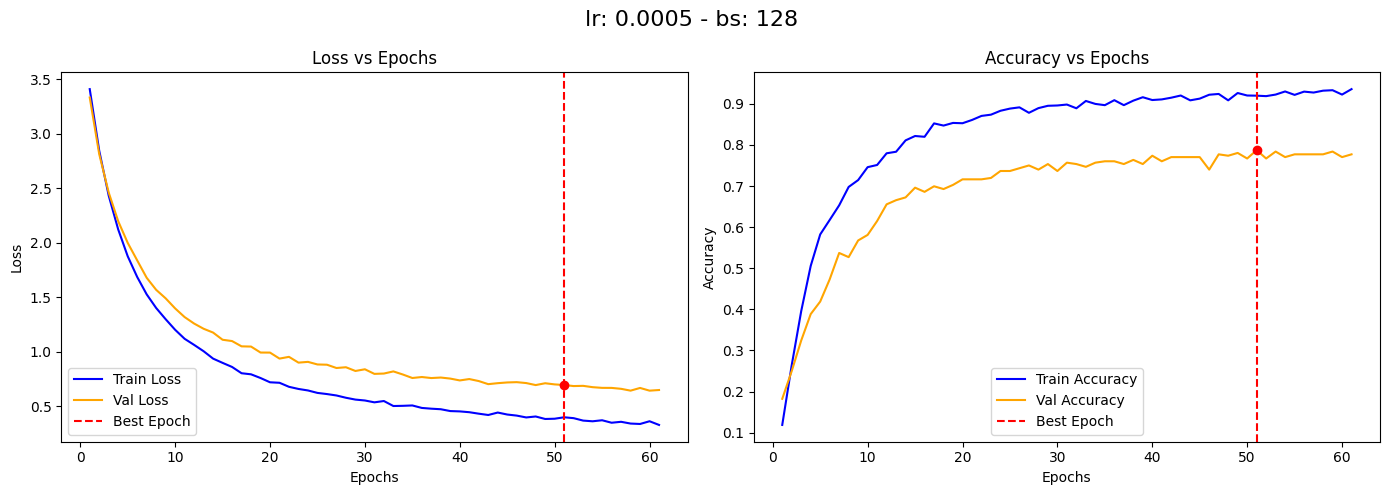


Early stopping triggered. Best validation accuracy of 0.814189 found at epoch 45.


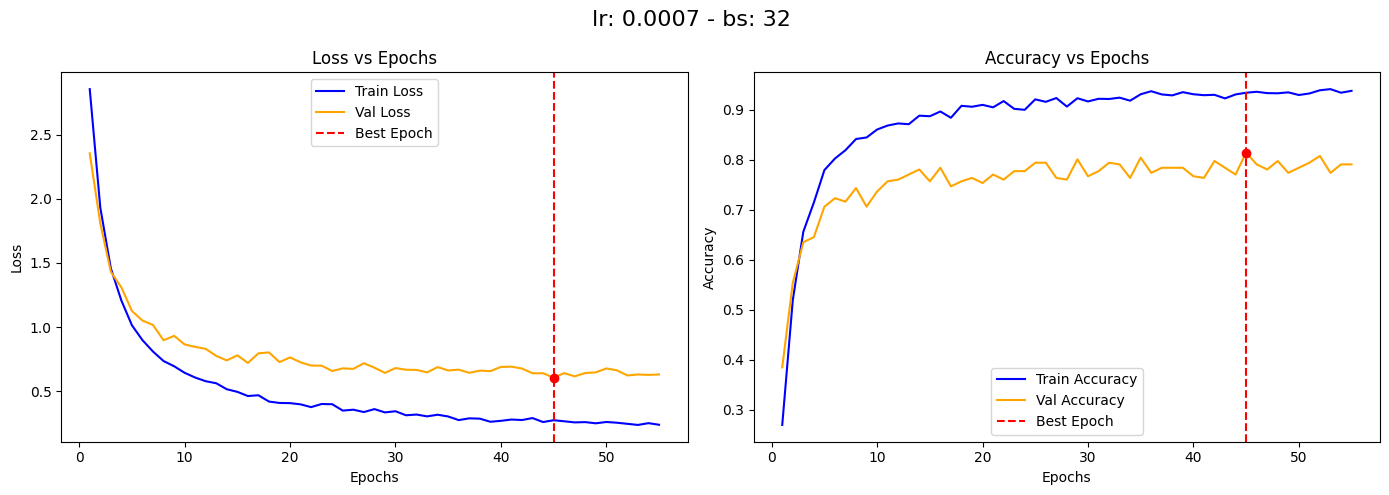


Early stopping triggered. Best validation accuracy of 0.793919 found at epoch 26.


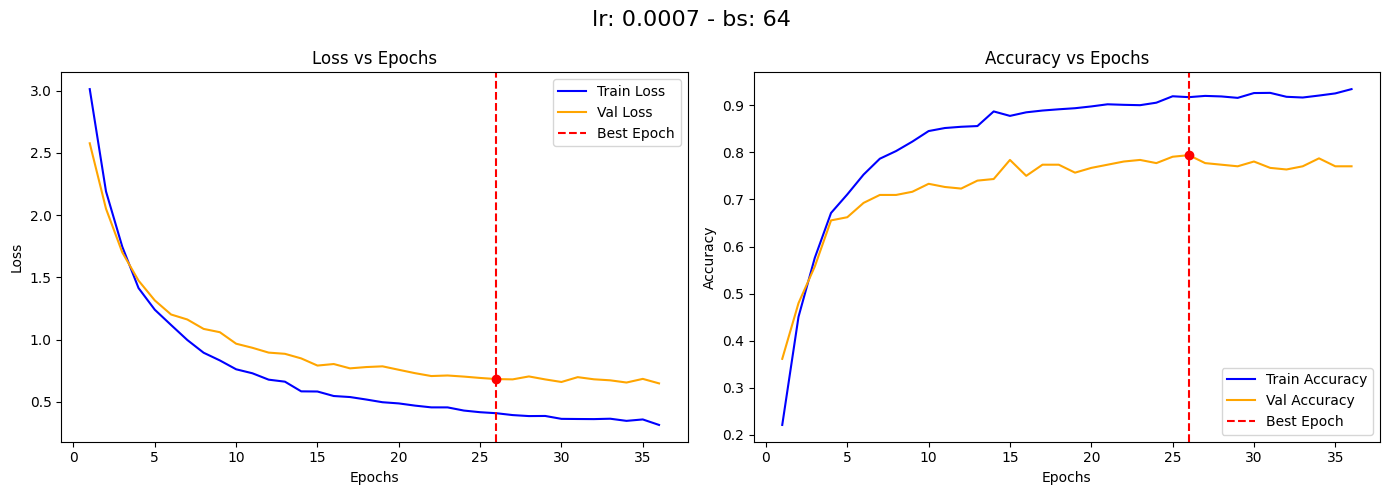


Early stopping triggered. Best validation accuracy of 0.800676 found at epoch 49.


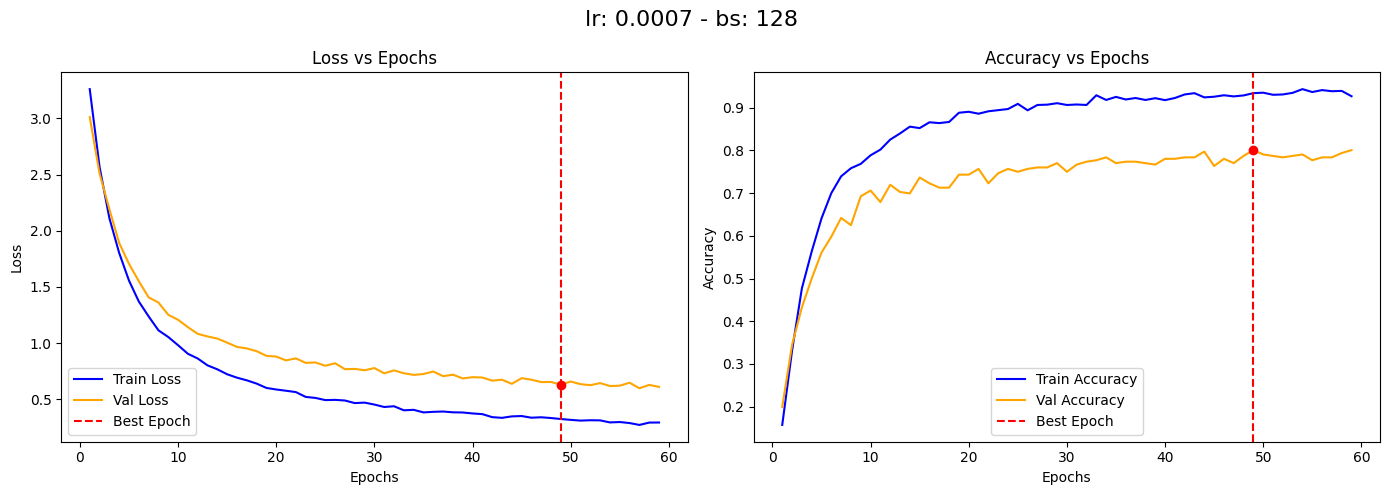


Early stopping triggered. Best validation accuracy of 0.793919 found at epoch 17.


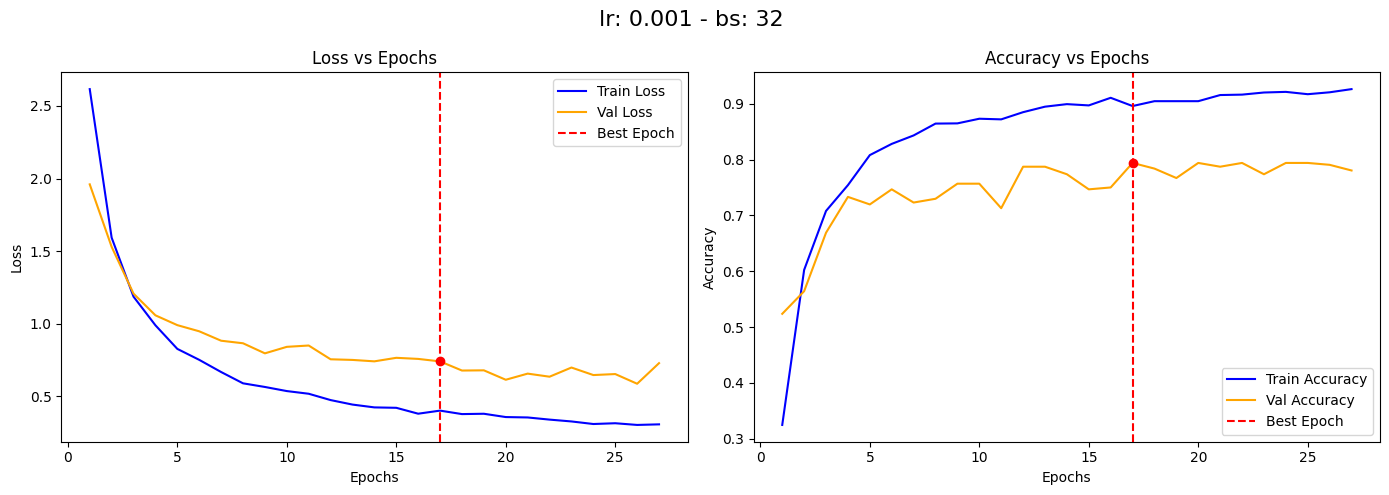


Early stopping triggered. Best validation accuracy of 0.817568 found at epoch 37.


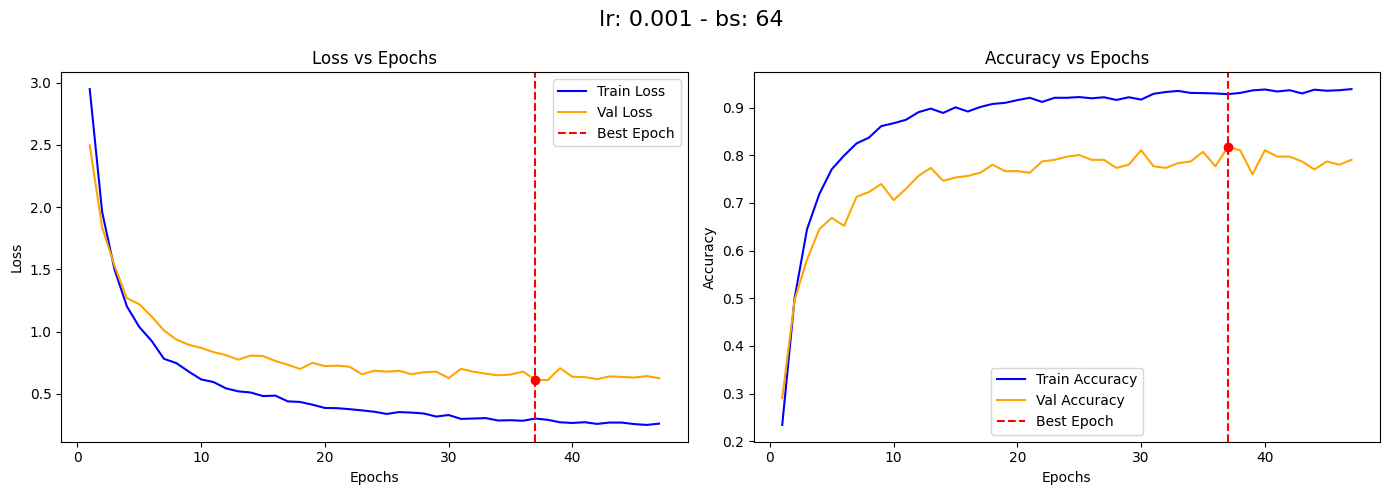


Early stopping triggered. Best validation accuracy of 0.814189 found at epoch 39.


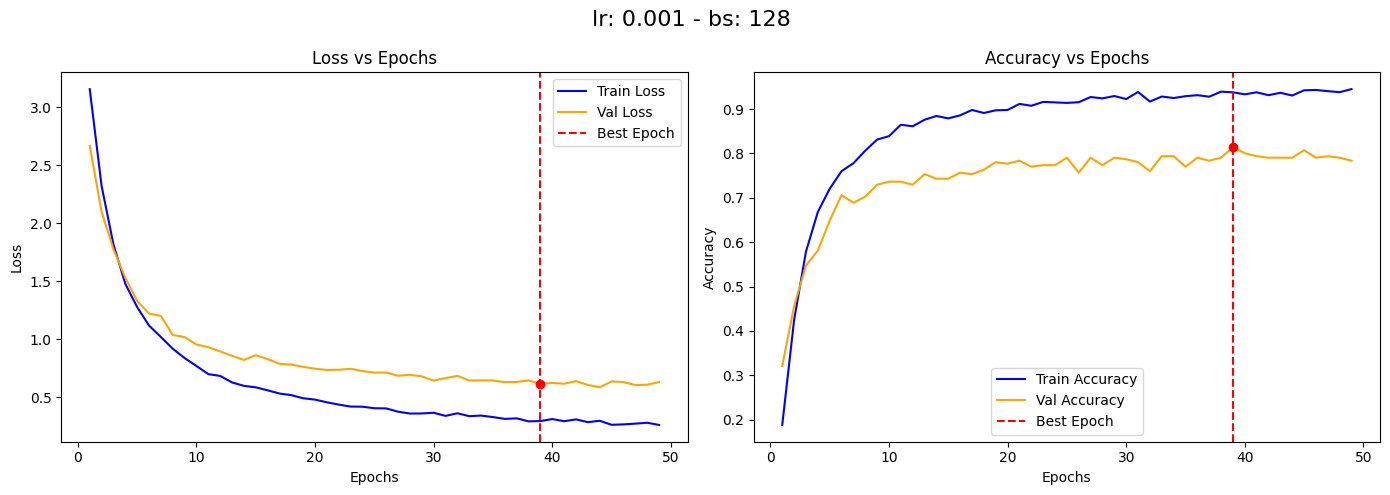

In [30]:
learning_rate_to_test = [3e-4, 5e-4, 7e-4, 1e-3]
batch_size_to_test = [32, 64, 128]
results_dict = {}

for learning_rate in learning_rate_to_test:
    for batch_size in batch_size_to_test:
        resnet18_v2 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)
        
        train_losses_resnet_v2, val_losses_resnet_v2, train_acc_resnet_v2, val_acc_resnet_v2, best_epoch_resnet_v2 = train_and_validate(resnet18_v2, 
                                                                                                             train_set.get_dataloader(batch_size, shuffle=True), 
                                                                                                             val_set.get_dataloader(batch_size, shuffle=False),
                                                                                                             criterion=nn.CrossEntropyLoss(),
                                                                                                             optimizer=optim.Adam(resnet18_v2.parameters(), lr=learning_rate),
                                                                                                             n_epochs=config["num_epochs"],
                                                                                                             device=device,
                                                                                                             patience=config["patience"],
                                                                                                             model_name="resnet18_v2",
                                                                                                             verbose=False)
        results_dict[(learning_rate, batch_size)] = max(val_acc_resnet_v2)
        
        plot_training_results(train_losses_resnet_v2, 
                              val_losses_resnet_v2, 
                              train_acc_resnet_v2, 
                              val_acc_resnet_v2, 
                              best_epoch_resnet_v2, 
                              title=f"lr: {learning_rate} - bs: {batch_size} ")
        print()

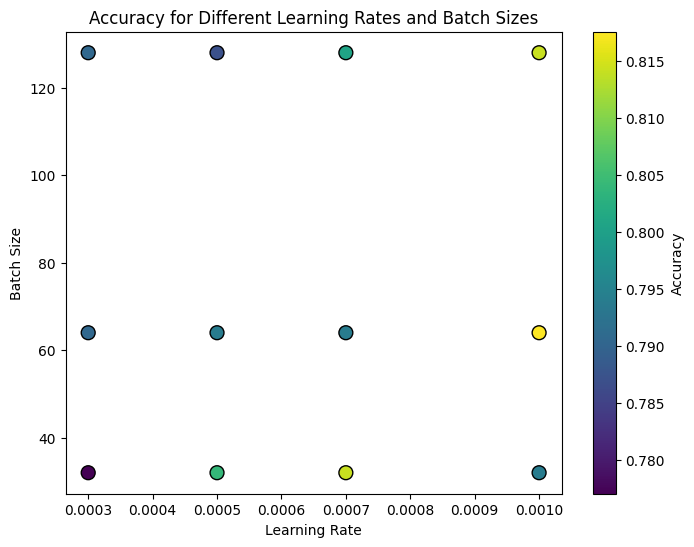

In [13]:
"""
{(0.0003, 32): 0.777027, (0.0003, 64): 0.790541, (0.0003, 128): 0.790541, (0.0005, 32): 0.804054, (0.0005, 64): 0.793919, (0.0005, 128): 0.787162, (0.0007, 32): 0.814189, (0.0007, 64): 0.793919, (0.0007, 128): 0.800676, (0.001, 32): 0.793919, (0.001, 64): 0.817568, (0.001, 128): 0.814189}
"""

# Extract learning rates, batch sizes, and accuracies
learning_rates = np.array([lr for lr, _ in results_dict.keys()])
batch_sizes = np.array([bs for _, bs in results_dict.keys()])
accuracies = np.array([acc for acc in results_dict.values()])

# Create the scatter plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(learning_rates, batch_sizes, c=accuracies, cmap='viridis', s=100, edgecolor='k')
plt.colorbar(scatter, label='Accuracy')

# Labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Accuracy for Different Learning Rates and Batch Sizes')

# Show plot
plt.show()

In [16]:
resnet18_v2 = get_resnet18(num_classes=43, weights=ResNet18_Weights.IMAGENET1K_V1)

In [17]:
# fine tuning with selected hyparameters
batch_size = 64
learning_rate = 1e-3
n_epochs = 100
patience = 10

train_losses_resnet_v2, val_losses_resnet_v2, train_acc_resnet_v2, val_acc_resnet_v2, best_epoch_resnet_v2 = train_and_validate(resnet18_v2, 
                                                                                                             train_set.get_dataloader(batch_size, shuffle=True), 
                                                                                                             val_set.get_dataloader(batch_size, shuffle=False),
                                                                                                             criterion=nn.CrossEntropyLoss(),
                                                                                                             optimizer=optim.Adam(resnet18_v2.parameters(), lr=learning_rate),
                                                                                                             n_epochs=n_epochs,
                                                                                                             device=device,
                                                                                                             patience=patience,
                                                                                                             model_name="resnet18_v2")


Epoch [1/100] Time: 10.94 seconds, Train Loss: 2.897711, Train Accuracy: 0.268939, Val Loss: 2.425394, Val Accuracy: 0.378378
Epoch [2/100] Time: 10.22 seconds, Train Loss: 1.908059, Train Accuracy: 0.534091, Val Loss: 1.847233, Val Accuracy: 0.506757
Epoch [3/100] Time: 11.78 seconds, Train Loss: 1.442358, Train Accuracy: 0.662500, Val Loss: 1.458715, Val Accuracy: 0.574324
Epoch [4/100] Time: 11.78 seconds, Train Loss: 1.198225, Train Accuracy: 0.724621, Val Loss: 1.269746, Val Accuracy: 0.679054
Epoch [5/100] Time: 11.50 seconds, Train Loss: 1.004020, Train Accuracy: 0.792803, Val Loss: 1.161126, Val Accuracy: 0.675676
Epoch [6/100] Time: 11.59 seconds, Train Loss: 0.881930, Train Accuracy: 0.812879, Val Loss: 1.084118, Val Accuracy: 0.733108
Epoch [7/100] Time: 12.19 seconds, Train Loss: 0.802229, Train Accuracy: 0.829167, Val Loss: 1.014144, Val Accuracy: 0.716216
Epoch [8/100] Time: 11.47 seconds, Train Loss: 0.704623, Train Accuracy: 0.850758, Val Loss: 0.933799, Val Accuracy: 0

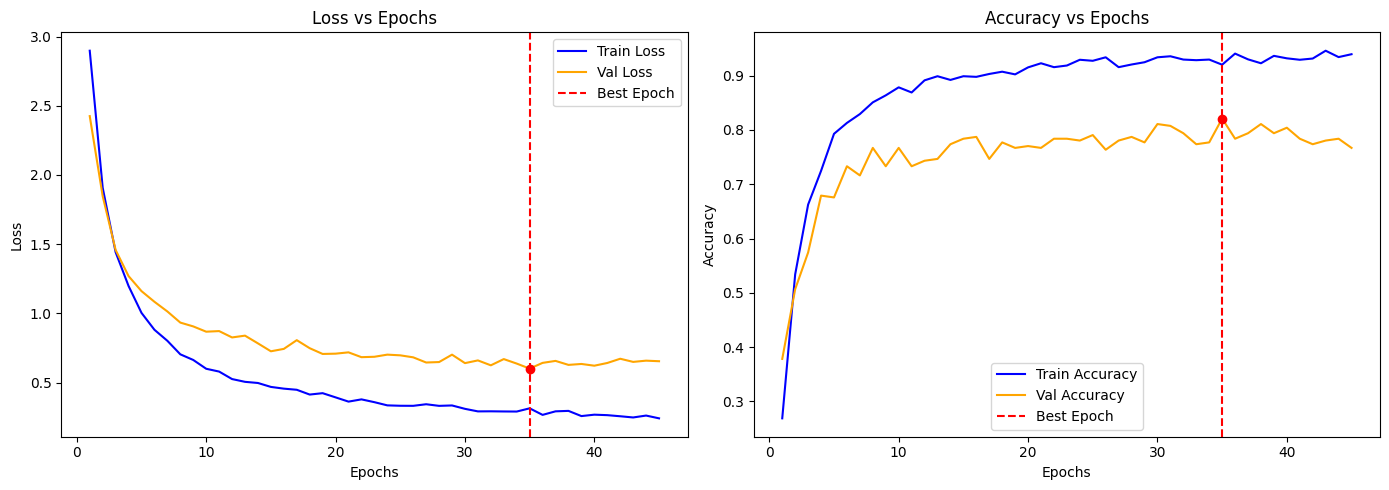

In [18]:
plot_training_results(train_losses_resnet_v2, val_losses_resnet_v2, train_acc_resnet_v2, val_acc_resnet_v2, best_epoch_resnet_v2)